<Br>

# Exploring the Connection: A Comprehensive Examination of BMI and Diabetes Prevalence through Confidence Intervals and Hypothesis Testing

## Project Group 26
### Names: Alex Lassooij, Hayden Hong, Yiguo Cao, Yoonha Jeon

<Br><Br>


## Introduction:

### Why is this important?
Diabetes mellitus, commonly referred to as diabetes, is a metabolic disorder characterized by high blood sugar levels over a prolonged period. It arises from either the inadequate production of insulin by the pancreas (Type 1 diabetes) or the body's ineffective use of insulin (Type 2 diabetes). Over time, diabetes can lead to serious health issues, including cardiovascular disease, vision loss, and kidney failure.

The Body Mass Index (BMI) is a key indicator of body fat derived from an individual's weight and height. Clinically, it is a heuristic proxy for categorizing individuals into various weight statuses, ranging from underweight to obese. An elevated BMI has been consistently linked to an increased risk of chronic health conditions, notably Type 2 diabetes. With obesity levels escalating globally, a scientific exploration of BMI as a predictive factor for diabetes is crucial. Such research could significantly contribute to preventive health measures and inform public health policies.

As obesity and diabetes emerge as two of the most challenging public health crises of the 21st century, it becomes essential to investigate the relationship between them. This investigation is not only key for understanding the etiology of diabetes but also instrumental in developing interventions to decrease the burden of this disease.

The study of the correlation between BMI and diabetes garnered significant attention and interest. For instance, a study that sought to examine the association between BMI and the occurrence of diabetes by comparing data from SHIELD 2004 and NHANES 1999-2002 found that 75% of individuals with diabetes had a BMI of 25 kg/m² or higher (Bays et al., 2007). Furthermore, the study analyzing NHANES data from 1999-2006 revealed a clear connection between BMI and diabetes prevalence. It demonstrated that as BMI increased, the prevalence of diabetes also increased. For example, individuals with a normal weight had an 8% diabetes rate, whereas those in the highest obesity class had a considerably higher rate of 43% (Nguyen et al., 2011).

#### Random Variables of Interest:
- Body Mass Index (kg/m^2)
#### Categories for Comparison:
- Individuals diagnosed with diabetes
- Individuals without diabetes


### The Dataset
The dataset we will use to explore this question is sourced from the National Institute of Diabetes and Digestive and Kidney Diseases. It consists of 768 samples of female above 21 years old of Pima Indian heritage. The dataset includes eight attributes plus the target variable (Outcome) : 

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1)

Since our random variable of interest is the BMI, we will drop all other features from the dataset. 


### Location Parameter:
The mean BMI will be utilized as the location parameter. The mean provides a central value around which the BMI values of each group (those with diabetes and those without) aggregate. This will offer a clear comparative metric to understand the average BMI in each group and potentially draw a direct connection to diabetes prevalence.


### Scale Parameter:
The standard deviation of BMI within each group will serve as the scale parameter. The standard deviation will give insights into the variability of BMI among individuals with and without diabetes. This measure is critical to understanding the range of BMIs present in each category and to assess the dispersion around the mean BMI, indicating the homogeneity or heterogeneity within each group. 

<Br><Br>

## Preliminary Results 

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(ggplot2) 
library(gridExtra)

── Attaching core tidyverse packages ─────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
#Our diabetes sample

diabetes_data <- read_csv("data/diabetes.csv", show_col_types = FALSE)
head(diabetes_data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


## Procedure:

Firstly, we are going to create two bootstrap distributions for the BMI for patients with diabetes and patients with no diabetes. We will visualize using histogram to see if the sample mean distributions "significantly" overlap. If they don't overlap, this may suggest that there is a relationship between a person's BMI and them being diabetic.

In [3]:
# Convert target variable to a categorical variable
diabetes_data$Outcome[diabetes_data$Outcome==1] <- "Positive"
diabetes_data$Outcome[diabetes_data$Outcome==0] <- "Negative"

In [4]:
# We are going to split the data into 2 different analysis. One will be patients with diabetes, 
# and the other will be patients with no diabetes

diabetes_positive <- diabetes_data |>
filter(!is.na(BMI) & Outcome == "Positive") |>
select(BMI, Outcome)

diabetes_negative <- diabetes_data |>
filter(!is.na(BMI) & Outcome == "Negative") |>
select(BMI, Outcome)

# data for all patients with diabetes
head(diabetes_positive)
# data for all patients with no diabetes
head(diabetes_negative)

BMI,Outcome
<dbl>,<chr>
33.6,Positive
23.3,Positive
43.1,Positive
31.0,Positive
30.5,Positive
0.0,Positive


BMI,Outcome
<dbl>,<chr>
26.6,Negative
28.1,Negative
25.6,Negative
35.3,Negative
37.6,Negative
27.1,Negative


<Br>

### Generate Bootstrap Distributions for Positive and Negative Classes by Separating Diabetic and Non-Diabetic Data Tables

In [5]:
set.seed(1234)

# Generating bootstrap distribution and calculating mean BMI for positive diabetic patients and negative diabetic patients

# The number of positive diabetic patients in our sample (we will be using 4000 reps for accuracy)
diabetes_positive_bootstrap_dist <- diabetes_positive |>
specify(response = BMI)|>
generate(type = "bootstrap", reps = 4000) |>
calculate(stat = "mean")


# The number of negative diabetic patients in our sample (we will be using 4000 reps for accuracy)
diabetes_negative_bootstrap_dist <- diabetes_negative |>
specify(response = BMI) |>
generate(type = "bootstrap", reps = 4000) |>
calculate(stat = "mean")

head(diabetes_positive_bootstrap_dist)
head(diabetes_negative_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,34.76828
2,34.71679
3,34.64515
4,35.18433
5,36.22313
6,34.89216


replicate,stat
<int>,<dbl>
1,30.1888
2,29.7176
3,29.9538
4,30.1112
5,29.8544
6,30.3984


<Br>

### Creating a summary data frame to collate results for both positive and negative cases:

In [6]:
positive_mean = mean(diabetes_positive_bootstrap_dist$stat)
positive_std_error = sd(diabetes_positive_bootstrap_dist$stat) / sqrt(nrow(diabetes_positive_bootstrap_dist))
negative_mean = mean(diabetes_negative_bootstrap_dist$stat)
negative_std_error = sd(diabetes_negative_bootstrap_dist$stat) / sqrt(nrow(diabetes_negative_bootstrap_dist))

diabetes_summary <- data.frame(
    diabetic = c("Positive", "Negative"),
    mean = c(positive_mean, negative_mean),
    std_error = c(positive_std_error, negative_std_error)
    
)

diabetes_summary

diabetic,mean,std_error
<chr>,<dbl>,<dbl>
Positive,35.15114,0.006948639
Negative,30.30548,0.005341457


<Br>

### Visualization:

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


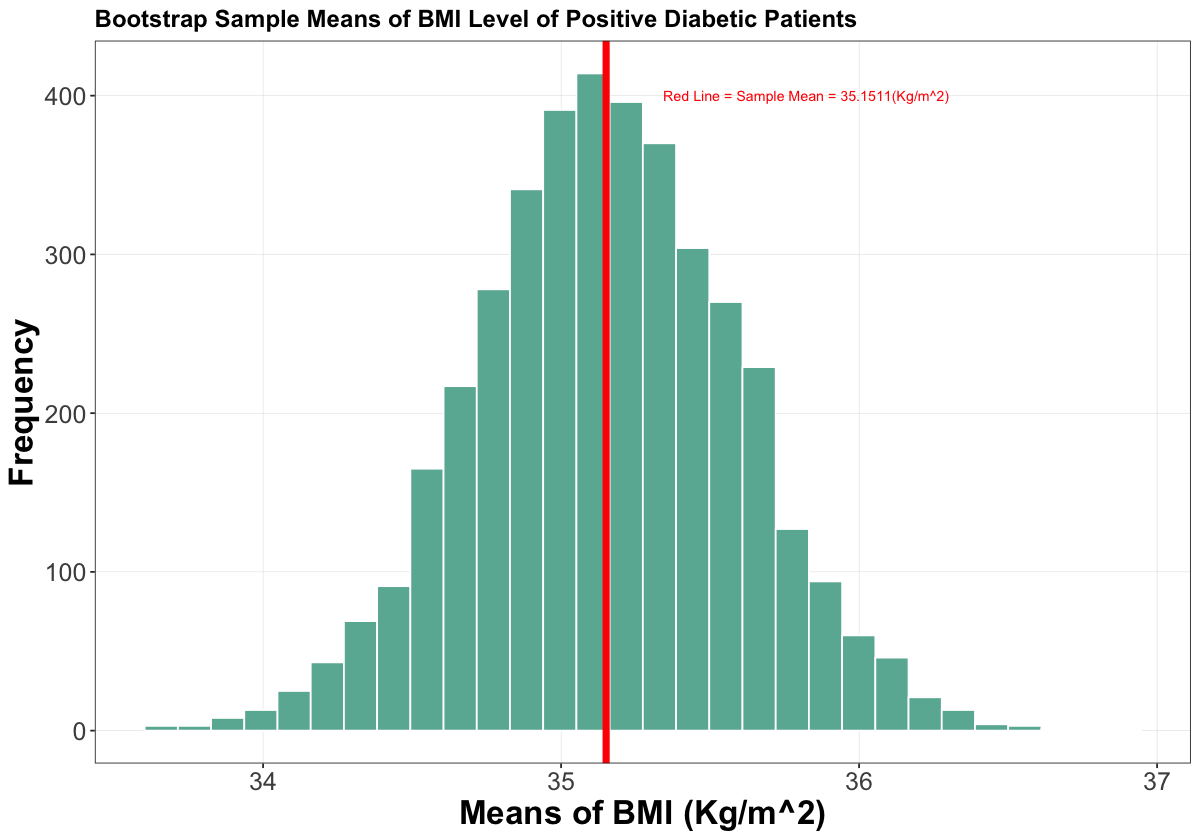

In [7]:
# Create histogram for diabetes positive bootstrapping distrubtion
options(repr.plot.width=10, repr.plot.height=7)

diabetes_positive_bootstrap_dist_visual <- diabetes_positive_bootstrap_dist %>%
  ggplot(aes(x = stat)) +
  geom_histogram(bins = 30, fill = "#69b3a2", color = "white") +
  theme_bw() +
  labs(
    x = "Means of BMI (Kg/m^2)",
    y = "Frequency",
    title = "Bootstrap Sample Means of BMI Level of Positive Diabetic Patients"
  ) +
  geom_vline(xintercept = positive_mean,
             size = 2,
             colour = "red") +
  annotate("text", x = positive_mean, y = 400, label = "Red Line = Sample Mean = 35.1511(Kg/m^2)", colour = "red", size = 3, hjust = -0.2) +
  theme(
    text = element_text(size = 18),
    axis.title = element_text(size = 20, face = "bold"),
    title = element_text(size = 12, face = "bold"),
    plot.background = element_rect(fill = "white"),
    panel.grid.major = element_line(size = 0.1, linetype = 'solid', colour = "lightgray"),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 15)
  )

diabetes_positive_bootstrap_dist_visual

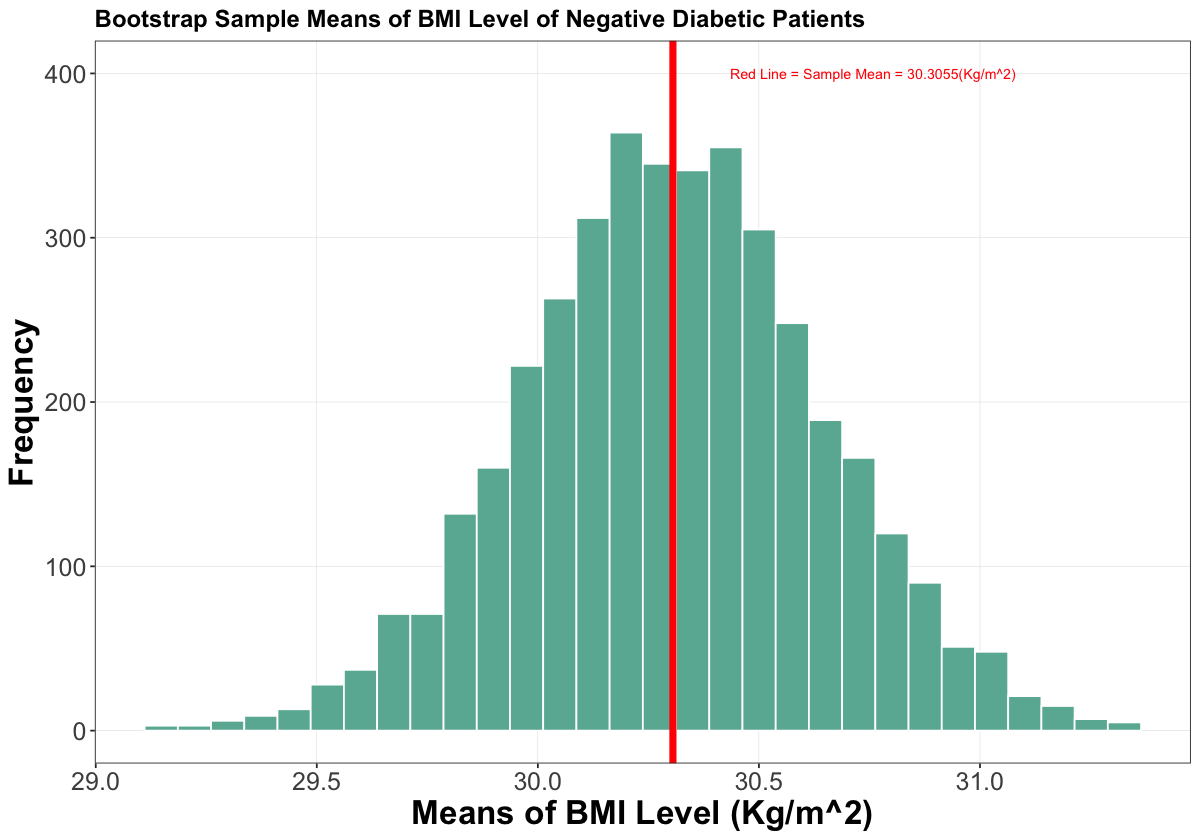

In [8]:
# Create histogram for negative diabetes bootstrapping distrubtion

diabetes_negative_bootstrap_dist_visual <- diabetes_negative_bootstrap_dist %>%
  ggplot(aes(x = stat)) +
  geom_histogram(bins = 30, fill = "#69b3a2", color = "white") +
  theme_bw() +
  labs(
    x = "Means of BMI Level (Kg/m^2)",
    y = "Frequency",
    title = "Bootstrap Sample Means of BMI Level of Negative Diabetic Patients"
  ) +  geom_vline(xintercept = negative_mean,
               size = 2,
               colour = "red") + 
annotate("text", x = negative_mean, y = 400, label = "Red Line = Sample Mean = 30.3055(Kg/m^2)", colour = "red", size = 3, hjust = -0.2) +
  theme(
    text = element_text(size = 18),
    axis.title = element_text(size = 20, face = "bold"),
    title = element_text(size = 12, face = "bold"),
    plot.background = element_rect(fill = "white"),
    panel.grid.major = element_line(size = 0.1, linetype = 'solid', colour = "lightgray"),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 15)
      
  )

diabetes_negative_bootstrap_dist_visual

<Br>

### Comparing The Cariance of Positive Diabetic Patients and Negative Diabetic Patients Bootstrapping Distrubutions:

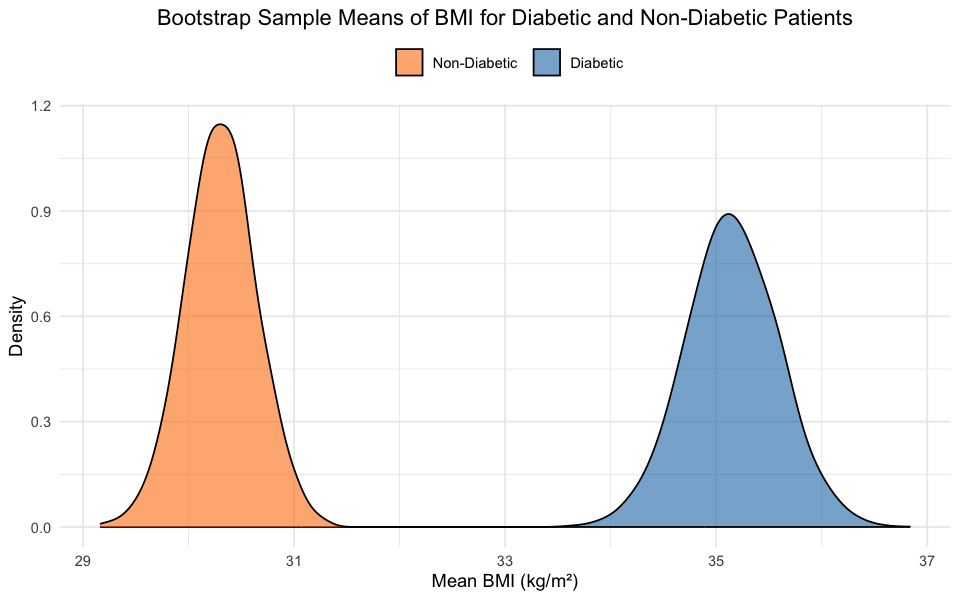

In [9]:
options(repr.plot.width=8, repr.plot.height=5)


# Assuming diabetes_positive_bootstrap_dist and diabetes_negative_bootstrap_dist are available data frames
overlap_data <- data.frame(
  value = c(diabetes_positive_bootstrap_dist$stat, diabetes_negative_bootstrap_dist$stat),
  group = rep(c("Diabetic", "Non-Diabetic"), each = 4000)
)


overlap_plot <- ggplot(overlap_data, aes(x = value, fill = group)) +
  geom_density(alpha = 0.6, adjust = 1.5) +
  scale_fill_manual(values = c("#1f77b4", "#ff7f0e")) + 
  theme_minimal() +
  theme(legend.title = element_blank(), 
        legend.position = "top",
        plot.title = element_text(hjust = 0.5)) + 
  labs(title = "Bootstrap Sample Means of BMI for Diabetic and Non-Diabetic Patients", 
       x = "Mean BMI (kg/m²)", 
       y = "Density") +
  guides(fill = guide_legend(reverse = TRUE)) 

# To view the plot
print(overlap_plot)





### Preliminary Results Conclusion:

The graph above provides compelling evidence that, within our sample, diabetic patients generally have a higher BMI when compared to non-diabetic patients. This marked difference, especially without any overlap, accentuates the potential relationship between `BMI` and diabetes. However, it's essential to understand that correlation does not imply causation, and further studies might be needed to determine if, and how, BMI directly influences diabetes onset. Moreover, just by observing the two distributions side by side, we can tell that the `BMI` of the diabetic individuals has a higher standard error than individuals who do not have diabetes. However, this difference is small enough to believe that there might not be any substantial difference to conclude that diabetic individuals do possess a higher variability among the population. We can perform hypothesis testing, a robust statistical method to analyze if there is enough evidence to conclude that people with diabetes do possess a higher variability or standard error.

## Methods - Plan
The report's trustworthiness is underlined by its clear visual representation, particularly the distinct plot comparing diabetic and non-diabetic groups. Its use of bootstrap sampling, a known statistical method, enhances result reliability. The evident separation in the data distributions minimizes ambiguity, and the report's objective approach ensures credibility. Moreover, by addressing both central tendencies and data variability, the report provides a well-rounded analysis. Lastly, acknowledging its limitations assures readers of the report's balanced perspective. Overall, its methodological rigor and transparent presentation make the report highly trustworthy.

Based on the two bootstrap distributions of sample means side-by-side and the mean shown above, we can clearly see that there is a relationship between BMI and diabetes. Patients without diabetes seem to have a lower BMI on average compared to those with diabetes. Additionally, the second plot that includes both distributions shows no overlap, indicating a strong difference in the outcome of our random variable of interest across the two categories.

The findings above may lead one to conclude that a high BMI is directly tied to being diabetic. However, we would like to clarify that we are simply looking to determine if diabetics tend to have a higher BMI than their non-diabetic counterparts, and are not suggesting or claiming that a high BMI is a cause of diabetes. In other words, relationship is not causation.

Additionally, we've observed that the variability of BMI for diabetic patients is higher than non diabetic patients. This suggests that the BMI values for diabetic individuals deviate more from their average. Delving deeper, this heightened variability could imply a diverse health profile within the diabetic group. It could imply that there are both diabetic people who control their illness successfully through healthy lifestyle choices and others who do not, resulting in a larger range of BMI readings. This substantial variability may also be symptomatic of a variety of factors influencing diabetic patients' BMI more distinctly than non-diabetic persons. Such factors could encompass diet, exercise, genetic factors, etc.


Admittedly, while our bootstrap distributions of sample means visually suggest a pronounced difference in BMI between diabetics and non-diabetics among females of at least 21 years old of Pima Indian heritage, it's crucial not to draw conclusions based solely on these visuals. Since these are only bootstrap samples, they only provide us with sample statistics of the one sample taken from the original population, so we cannot defend our claim with confidence. A deeper statistical inference, rather than just a visual representation, is required to offer a solid foundation for any findings. Therefore, we will build confidence intervals for each group using both bootstrapping and CLT methods. A confidence interval will provide a range of plausible values for the true population mean, allowing us to assess the precision of our estimate and to make inferences about the population parameter. If the confidence intervals for the two groups do not overlap, this provides initial evidence that the means are significantly different.


**OUTCOME AND INFLUENCES:**

Furthermore, we must determine whether the difference in BMI is due to chance or due to a true difference in our random variable's outcome. We will conduct a hypothesis test to evaluate if there is sufficient evidence to support our claim. The null hypothesis will state that there is no difference in means of BMI between individuals diagnosed with diabetes and those without diabetes., while the alternative hypothesis will posit that there is a difference. A low p-value (typically less than 0.05) would lead us to reject the null hypothesis, providing statistical evidence of a difference in means.

If a notable difference in BMI between diabetics and non-diabetics is confirmed, it will enhance the understanding of the relationship between obesity and diabetes, even though this study doesn't establish causality. While existing studies has illuminated the linkage between obesity and diabetes, our investigation aims to strengthen this view by offering additional  evidence. Besides, given the increased risk of diabetes, medical professionals could emphasize preventive measures for people with higher BMIs. Moving forward, a future question could be to explore how the other variables in the dataset interact with `BMI` concerning diabetes. For instance, is there an interaction effect between `Age` and `BMI` in predicting diabetes?

<Br><Br>

## References
- Bays, H. E., Chapman, R. H., Grandy, S., & the SHIELD Investigators’ Group. (2007). The Relationship of Body Mass Index to Diabetes Mellitus, Hypertension, and Dyslipidemia: Comparison of Data from Two National Surveys. Published on April 10, 2007.
https://onlinelibrary.wiley.com/doi/full/10.1111/j.1742-1241.2007.01336.x
- Nguyen, N.T., Nguyen, X.M.T., Lane, J., et al. (2011). Relationship Between Obesity and Diabetes in a US Adult Population: Findings from the National Health and Nutrition Examination Survey, 1999–2006. Obes Surg, 21, 351–355.
https://doi.org/10.1007/s11695-010-0335-4

## Methods and Results

**DRAFT:** We will first create a confidence interval for both the bootrap distrubutions of people with diabetes and non diabetes. With this confidence interval, we can make an inference to the population means from both categories and check if there is significant overlap amongst the population. This will give us a general idea if there is a difference in means between the 2 categories. Since we only have samples of the population and not the actual population. We will conduct a student T confidence interval. We will conduct a 90% confidence interval

In [10]:
#Lets first rename each columns 

diabetes_positive_bootstrap_dist <- diabetes_positive_bootstrap_dist |>
rename(positive_bootstrap_samples = stat)

diabetes_negative_bootstrap_dist <- diabetes_negative_bootstrap_dist |>
rename(negative_bootstrap_samples = stat)

head(diabetes_positive_bootstrap_dist)
head(diabetes_negative_bootstrap_dist)

replicate,positive_bootstrap_samples
<int>,<dbl>
1,34.76828
2,34.71679
3,34.64515
4,35.18433
5,36.22313
6,34.89216


replicate,negative_bootstrap_samples
<int>,<dbl>
1,30.1888
2,29.7176
3,29.9538
4,30.1112
5,29.8544
6,30.3984


In [11]:
# Lets calculate the T-Statistic / critical value with 90% confidence level for positive diabetes

t_stat_positive <- qt(0.95, nrow(diabetes_positive_bootstrap_dist) - 1, lower.tail = TRUE)
t_stat_positive

# Lets calculate the T-Statistic / critical value with 90% confidence level for negative diabetes (non diabetes)

t_stat_negative <- qt(0.95, nrow(diabetes_negative_bootstrap_dist) - 1, lower.tail = TRUE)
t_stat_negative

#As we can see, since for each bootstrap sample has the same number of rows, we get the same critical value.
# So the test statistic for both are the exact same

t_stat <- t_stat_positive

[1] 1.645235

[1] 1.645235

We Will now create the actual confidence interval with a level of 90%

In [12]:
# Confidence Interval for patients with positive diabetes 

x_bar_positive <- mean(diabetes_positive_bootstrap_dist$positive_bootstrap_samples)
x_bar_negative <- mean(diabetes_negative_bootstrap_dist$negative_bootstrap_samples)

sd_positive <- sd(diabetes_positive_bootstrap_dist$positive_bootstrap_samples)
sd_negative <- sd(diabetes_negative_bootstrap_dist$negative_bootstrap_samples)

n_positive <- nrow(diabetes_positive_bootstrap_dist)
n_negative <- nrow(diabetes_negative_bootstrap_dist)



positive_diabetes_ci <- tibble(lower_ci = x_bar_positive - (t_stat * (sd_positive / sqrt(n_positive))),
                               upper_ci = x_bar_positive + (t_stat * (sd_positive / sqrt(n_positive))))


negative_diabetes_ci <- tibble(lower_ci = x_bar_negative - (t_stat * (sd_negative / sqrt(n_negative))),
                               upper_ci = x_bar_negative + (t_stat * (sd_negative / sqrt(n_negative))))

positive_diabetes_ci
negative_diabetes_ci

lower_ci,upper_ci
<dbl>,<dbl>
35.13971,35.16257


lower_ci,upper_ci
<dbl>,<dbl>
30.2967,30.31427


Warning message:
“Removed 3844 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 3825 rows containing non-finite values (`stat_density()`).”


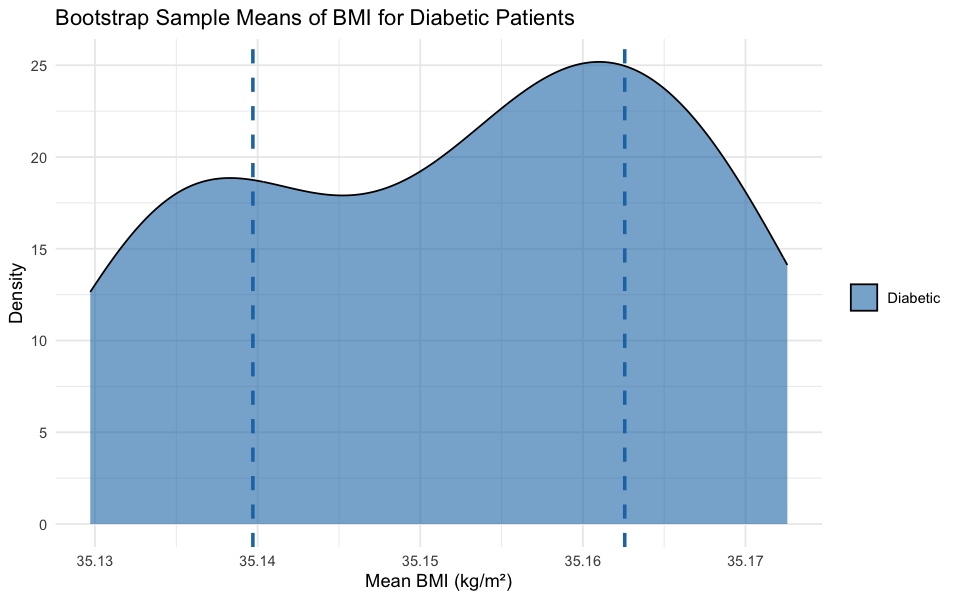

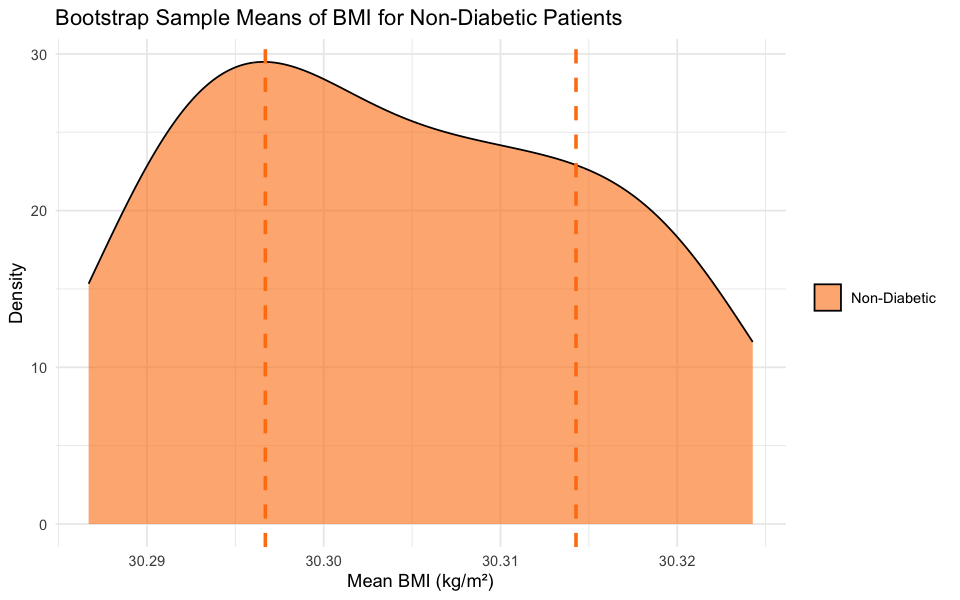

In [13]:

buffer <- 0.01

# For the Diabetic plot
# Define limits around the confidence intervals for Diabetic group
diabetic_x_lower <- positive_diabetes_ci$lower_ci[1] - buffer
diabetic_x_upper <- positive_diabetes_ci$upper_ci[1] + buffer

diabetic_plot <- ggplot(diabetes_positive_bootstrap_dist, aes(x = positive_bootstrap_samples, fill = "Diabetic")) +
  geom_density(alpha = 0.6, adjust = 1.5) +
  scale_fill_manual(values = "#1f77b4", guide = guide_legend(title = NULL)) +
  theme_minimal() +
  labs(title = "Bootstrap Sample Means of BMI for Diabetic Patients", 
       x = "Mean BMI (kg/m²)", 
       y = "Density") +
  geom_vline(xintercept = positive_diabetes_ci$lower_ci[1], linetype = "dashed", color = "#1f77b4", size = 1) +
  geom_vline(xintercept = positive_diabetes_ci$upper_ci[1], linetype = "dashed", color = "#1f77b4", size = 1) +
  xlim(diabetic_x_lower, diabetic_x_upper)  # Set tighter x-axis limits

# For the Non-Diabetic plot
# Define limits around the confidence intervals for Non-Diabetic group
non_diabetic_x_lower <- negative_diabetes_ci$lower_ci[1] - buffer
non_diabetic_x_upper <- negative_diabetes_ci$upper_ci[1] + buffer

non_diabetic_plot <- ggplot(diabetes_negative_bootstrap_dist, aes(x = negative_bootstrap_samples, fill = "Non-Diabetic")) +
  geom_density(alpha = 0.6, adjust = 1.5) +
  scale_fill_manual(values = "#ff7f0e", guide = guide_legend(title = NULL)) +
  theme_minimal() +
  labs(title = "Bootstrap Sample Means of BMI for Non-Diabetic Patients", 
       x = "Mean BMI (kg/m²)", 
       y = "Density") +
  geom_vline(xintercept = negative_diabetes_ci$lower_ci[1], linetype = "dashed", color = "#ff7f0e", size = 1) +
  geom_vline(xintercept = negative_diabetes_ci$upper_ci[1], linetype = "dashed", color = "#ff7f0e", size = 1) +
  xlim(non_diabetic_x_lower, non_diabetic_x_upper)  # Set tighter x-axis limits

# To view the plots
print(diabetic_plot)
print(non_diabetic_plot)


**DRAFT:** The dashed lines represent the confidence intervals for a level of 90%. In both cases we have zoomed into both graphs to actually see the confidence interval gaps. The reason for confidence intervals gaps to be relatively very very small is because we are dealing with a very large sample size (reps = 4000) with very small variation. Hence

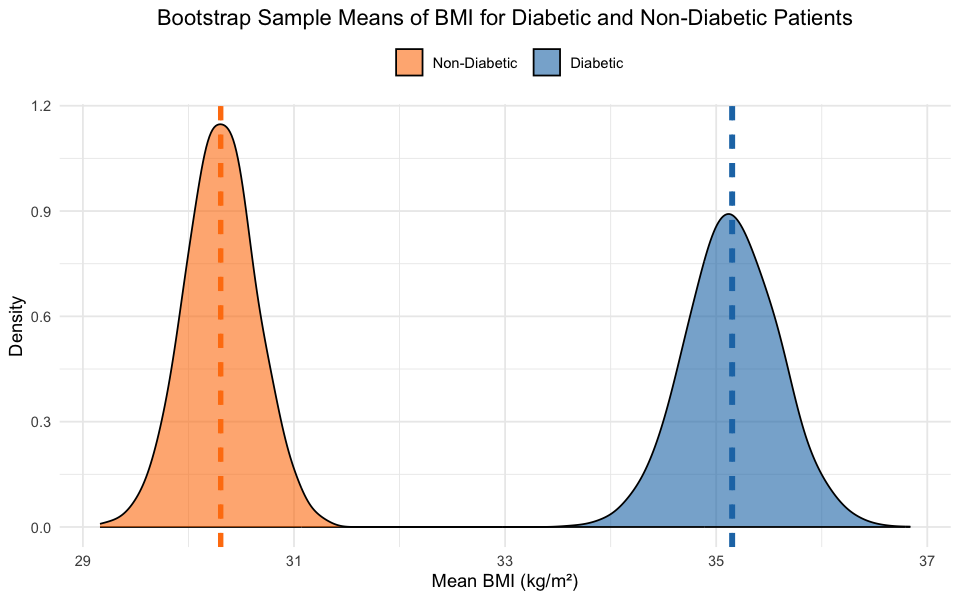

In [14]:
options(repr.plot.width=8, repr.plot.height=5)


# Assuming diabetes_positive_bootstrap_dist and diabetes_negative_bootstrap_dist are available data frames
overlap_data <- data.frame(
  value = c(diabetes_positive_bootstrap_dist$positive_bootstrap_samples, diabetes_negative_bootstrap_dist$negative_bootstrap_samples),
  group = rep(c("Diabetic", "Non-Diabetic"), each = 4000)
)


overlap_plot <- ggplot(overlap_data, aes(x = value, fill = group)) +
  geom_density(alpha = 0.6, adjust = 1.5) +
  scale_fill_manual(values = c("#1f77b4", "#ff7f0e")) + 
  theme_minimal() +
  theme(legend.title = element_blank(), 
        legend.position = "top",
        plot.title = element_text(hjust = 0.5)) + 
  labs(title = "Bootstrap Sample Means of BMI for Diabetic and Non-Diabetic Patients", 
       x = "Mean BMI (kg/m²)", 
       y = "Density") +
  guides(fill = guide_legend(reverse = TRUE)) +
geom_vline(xintercept = positive_diabetes_ci$lower_ci[1], linetype = "dashed", color = "#1f77b4", size = 1) +
  geom_vline(xintercept = positive_diabetes_ci$upper_ci[1], linetype = "dashed", color = "#1f77b4", size = 1) +
  geom_vline(xintercept = negative_diabetes_ci$lower_ci[1], linetype = "dashed", color = "#ff7f0e", size = 1) +
  geom_vline(xintercept = negative_diabetes_ci$upper_ci[1], linetype = "dashed", color = "#ff7f0e", size = 1)

# To view the plot
print(overlap_plot)



**DRAFT:** This is the graphs side by side with there respective confidence intervals (dashed lines) and zoomed out. We can see that the confidence interval gap is so small that it basically looks like 1 dashed line for each category. For this we can conclude that the means of the sample for each category is very precise to the true population mean for each category. Also we can see that there is a no overlap between the 2 confidence and far apart which indicates that there is very reasonable assumption that difference in means of the 2 categories are statistically significant. However, we will perform hypothesis testing of difference in means to further justify our reasonings.

### Setting the Hypothesis
Using a simulation-based hypothesis test, we will verify whether our claim of the means for each category being different can be defended under a significance level of $\alpha = 0.01$ <br>
Our null hypothesis $H_0$ will state the there is no observable difference between the means of those with diabetes ($\mu_1$) and those without diabetes ($\mu_2$)
Our alternate hypothesis $H_1$ will state that there is in fact a significant difference between the means of our two categories :

$H_0: \mu_1 - \mu_2 = 0\qquad$ vs. $\qquad H_1: \mu_1-\mu_2 > 0$


In order to draw a conclusion, we need to obtain an observed test statistic :

In [15]:
obs_test_stat = mean(diabetes_positive$BMI) - mean(diabetes_negative$BMI)

obs_test_stat

[1] 4.838337

Our observed test statistic is clearly larger than zero. To verify that this is a representative test statistic, we will plot it together with a bootstrap distribution of the difference in means :  

In [26]:
set.seed(1234)

samp_dist_diff_means <- 
    diabetes_data %>% 
    specify(formula = BMI ~ Outcome) %>% 
    generate(type = "bootstrap", reps = 4000) %>% 
    calculate(stat = "diff in means", order = c("Positive", "Negative"))

mean_diff_means <- mean(samp_dist_diff_means$stat)
mean_diff_means

[1] 4.836899

In [22]:
diff_means_bootstrap_dist_visual <- samp_dist_diff_means %>%
  ggplot(aes(x = stat)) +
  geom_histogram(bins = 30, fill = "#69b3a2", color = "white") +
  theme_bw() +
  labs(
    x = "Difference in Means of BMI Level (Kg/m^2)",
    y = "Frequency",
    title = "Bootstrap Sample Difference in Means of BMI Level Between Positive and Negative Diabetic Patients"
  ) +  geom_vline(xintercept = obs_test_stat,
               size = 2,
               colour = "red") + 
annotate("text", x = obs_test_stat, y = 400, label = "Test Stat = 4.838(Kg/m^2)", colour = "red", size = 3, hjust = -0.2) +
  theme(
    text = element_text(size = 18),
    axis.title = element_text(size = 20, face = "bold"),
    title = element_text(size = 12, face = "bold"),
    plot.background = element_rect(fill = "white"),
    panel.grid.major = element_line(size = 0.1, linetype = 'solid', colour = "lightgray"),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 15)
      
  )

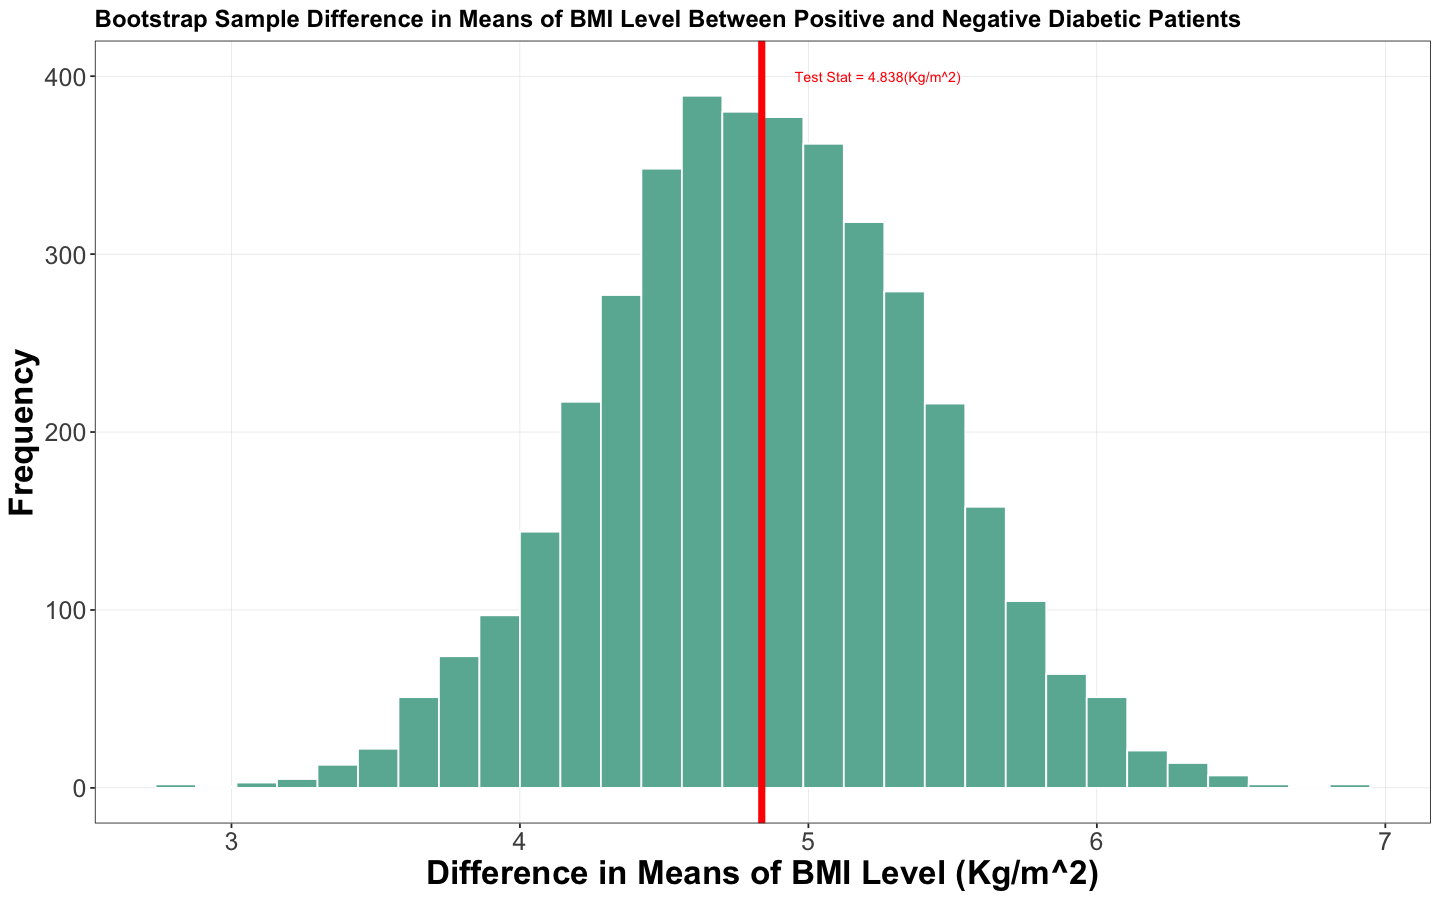

In [21]:
options(repr.plot.width=12, repr.plot.height=7.5)
diff_means_bootstrap_dist_visual

As expected, the bootstrap distribution of the difference in means is centered roughly at the observed test statistic. The actual mean of the bootstrap distribution is 4.836.

Now, we will examine our test statistic's sampling distribution under the null hypothesis. Similarly, we will again use a bootstrap distribution to examine how the sampling distribution of the difference in means would look like if the null hypothesis were true, i.e. the difference is centered at zero.

In [27]:
null_model_diabetes <- 
   diabetes_data %>% 
   specify(formula = BMI ~ Outcome) %>% 
   hypothesize(null = "independence") %>% 
   generate(reps = 4000, type = "permute") %>% 
   calculate(stat="diff in means", order = c("Positive", "Negative"))

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


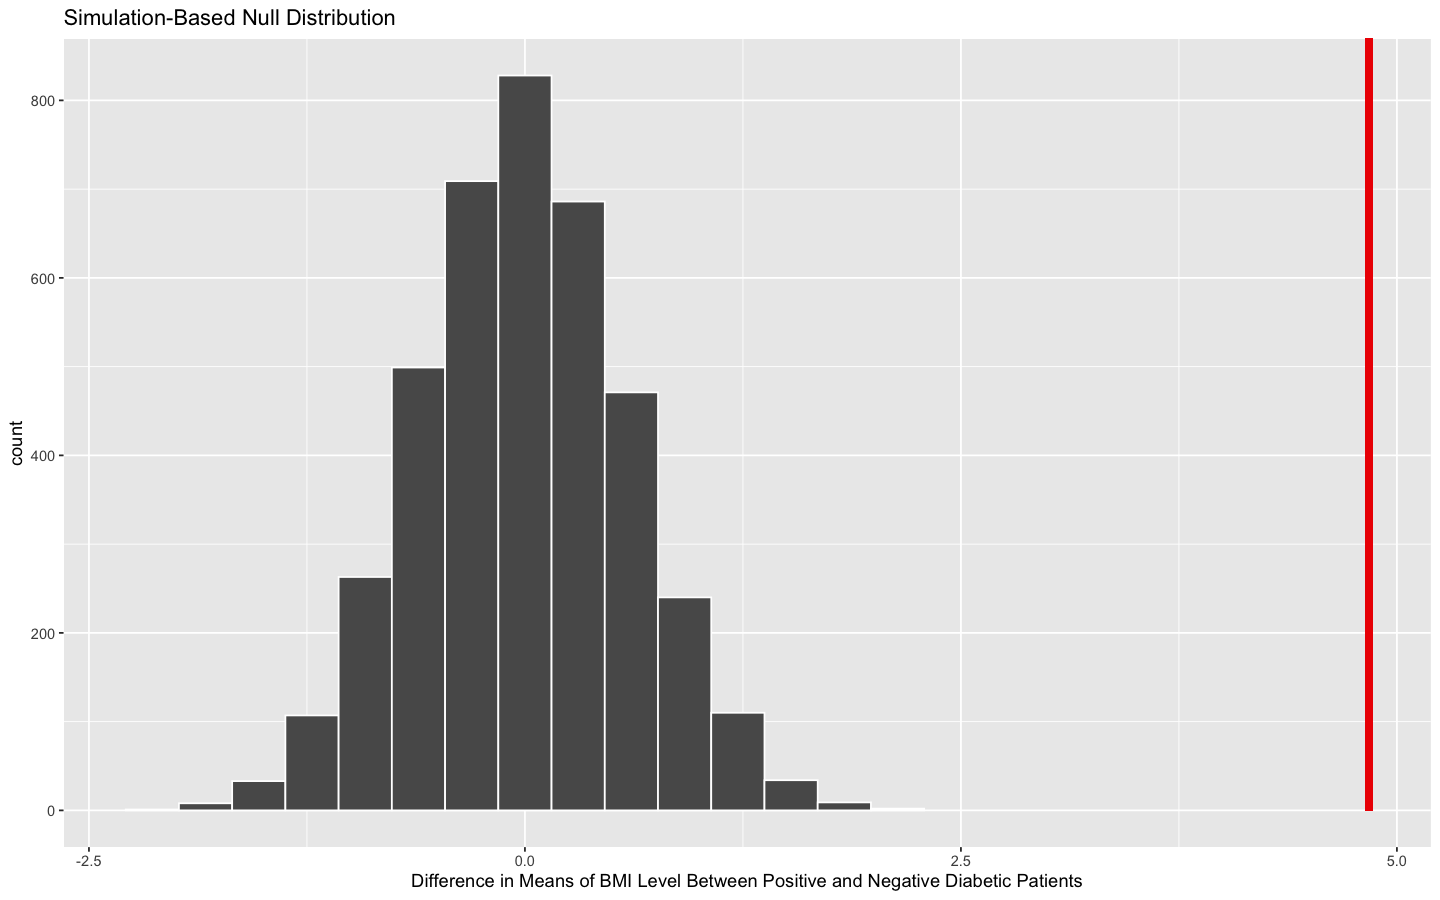

In [32]:
null_model_plot <- 
   null_model_diabetes %>%
   visualize(dens_color = "white") + 
   shade_p_value(obs_stat = obs_test_stat, direction = "right") +
   xlab("Difference in Means of BMI Level Between Positive and Negative Diabetic Patients")

null_model_plot

In [33]:
diff_means_p_value <- null_model_diabetes %>%
    get_p_value(obs_stat = obs_test_stat, direction = "right")

diff_means_p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


As we can see, the observed test statistic lies far outside the the sampling distribution of the null hypothesis, yielding a p-value of $p=0$. 
(add some discussion about reporting special case of a p-value equal to zero, and that we can reject the null hypothesis with full confidence, i.e. zero chance of committing a type I error)